In [1]:
import pandas
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import AdaBoostRegressor
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, cross_val_score

import plotly.express as px
import plotly.graph_objects as go
import hist2d

import plotly.io as pio
from IPython.display import Image

### Load data

In [2]:
df = pandas.read_pickle("../data/stats.xz")
df.drop(df[df["RUN"] != 2].index, axis=0, inplace=True)
df.reset_index(inplace=True)

#### Correct economic impact to make it comparable across scenarios

In [3]:
maxd = np.max(df["DURATION"].values)
df["WORKING"] = (maxd - df["DURATION"]) * df["DEATH"] + df["WORKING"]
df["WORKING"] = np.log10(df["WORKING"]/(maxd*df["NUM_AGENTS"]))

#### Remove variables that are either targets or are fixed throughout the simulations

In [4]:
targets = ["WORKING", "INFECTED", "SICK_PEAK", "DEATH", "DURATION"]
drops = ["WIDTH", "HEIGHT", "NUM_AGENTS", "FPS", "INITIAL_SICK", "AGENT_RADIUS", "DESEASE_DURATION", "RUN", "START_SPEED"]

x_cols = list(df.columns)
for col in (targets + drops):
    del x_cols[x_cols.index(col)]

#### Generate function to visualize death vs. economic loss (for interactive version and not static graphs uncomment here)

In [5]:
def show_results(hist, w_steps, d_steps, colorbar):
    c_vals = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]

    fig = go.Figure(data=go.Heatmap(z=hist, x=w_steps, y=d_steps, hoverongaps = False, colorbar = colorbar))
    x_vals = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]
    y_vals = [0.01, 0.05, 0.1, 0.15, 0.2]

    fig.update_layout(
        xaxis = dict(
            tickmode = 'array',
            tickvals = [np.log10(v) for v in x_vals],
            ticktext = [f"{v *100:.0f} %" for v in x_vals],
            title = "Total workhours lost [%]"
        ),
        yaxis = dict(
            tickmode = 'array',
            tickvals = y_vals,
            ticktext = [f"{v *100} %" for v in y_vals],
            title = "People died [%]"
        )
    )
    #uncomment to get static version
    return Image(pio.to_image(fig, format='png'))
    #uncomment to get interactive version
    #fig.show()

#### Function to add higher level cross-correlations between variables

In [6]:
def add_cross(a, cols):
    base_cols = list(cols)
    
    squares = a**2
    cols.extend(map(lambda x: x+"_SQR", base_cols))
    logs = np.log(a+1)
    cols.extend(map(lambda x: x+"_LOG", base_cols))
    sqrts = np.sqrt(a)
    cols.extend(map(lambda x: x+"_SQRT", base_cols))

    b = [a, squares, logs, sqrts]
    for i in range(len(base_cols)):
        for k in range(i+1, len(base_cols)):
            b.append((a[:, i] * a[:, k])[:,None])
            b.append(((a[:, i]+1) / (a[:, k]+1))[:,None])
            b.append((a[:, i] - a[:, k])[:,None])
            b.append((a[:, i] + a[:, k])[:,None])
            cols.append(base_cols[i] + "_MULT_" + base_cols[k])
            cols.append(base_cols[i] + "_DIV_" + base_cols[k])
            cols.append(base_cols[i] + "_DIFF_" + base_cols[k])
            cols.append(base_cols[i] + "_ADD_" + base_cols[k])
    return np.hstack(b), cols


#### Create data X for analysis and fitting to targets incl. adding cross-correlations

In [7]:
X = np.array(df[x_cols].values, dtype=np.float64)
X, x_cols = add_cross(X, x_cols)

#### Function to calculate most important features to predict a certain target

In [8]:
def get_importance(X, y, target_col, target):
    print(X.shape)
    imps = []
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

    regr_1 = DecisionTreeRegressor(max_depth=4, random_state=0).fit(X_train, y_train[:, target_col])
    
    dt_scores = cross_val_score(regr_1, X_train, y_train[:, target_col], cv = 5)

    print("mean cross validation score: {}".format(np.mean(dt_scores)))
    
    for i in np.argsort(regr_1.feature_importances_)[::-1]:
        imp = regr_1.feature_importances_[i]
        if imp > 0:
            imps.append(i)
            print("Coeff: %s : %.5f" % (x_cols[i], imp))
    p = regr_1.predict(X_test)
    return X_test, y_test, np.abs(y_test[:, target_col] - p)/y_test[:, target_col]

## Predicting Death rate

In [9]:
X_test, y_test, err = get_importance(X, df[["DEATH", "WORKING"]].values, 0, "Death rate")

(213308, 264)
mean cross validation score: 0.8171075662291717
Coeff: R_SPREAD_MULT_FATALITY : 0.94129
Coeff: KNOW_RATE_SICK_MULT_SD_IMPACT : 0.04210
Coeff: SD_IMPACT_DIV_SD_STOP : 0.01039
Coeff: KNOW_RATE_SICK_DIV_SD_START : 0.00350
Coeff: SD_START_MULT_SD_STOP : 0.00130
Coeff: SD_RECOVERED_DIFF_SD_STOP : 0.00099
Coeff: SD_IMPACT_DIV_SD_START : 0.00030
Coeff: R_SPREAD_MULT_SD_START : 0.00011


#### Understanding error of predictions

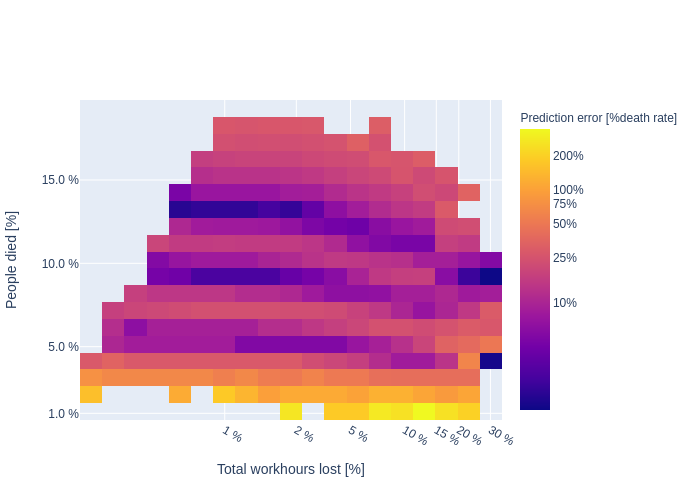

In [10]:
df_err = pandas.DataFrame(data={"WORKING":y_test[:, 1],
                            "DEATH": y_test[:, 0],
                            "error": np.log10(err)})
hist, d_steps, w_steps = hist2d.get2d_hist(df_err, bins=20, x="DEATH", y="WORKING", z="error", reduce_op=np.median)
c_vals = np.log10([0.10, 0.25, 0.5, 0.75, 1.0, 2.0, 4.0])
colorbar = dict(title="Prediction error [%death rate]", tickmode="array", tickvals=c_vals,
               ticktext=[f"{10**c * 100:.0f}%" for c in c_vals])
show_results(hist, w_steps, d_steps, colorbar)

Apparently, relative prediction error with this model is quite high, especially on the lower death rate regions. So the model can rather capture the midrange errors between 5 - 15% death rate. This needs to be kept in mind, when analyizing this further. Overall the accuracy of the model was given by ~82%.

#### Death rate key feature: R_SPREAD_MULT_FATALITY, i.e., Infectiousness x Fatality of desease

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



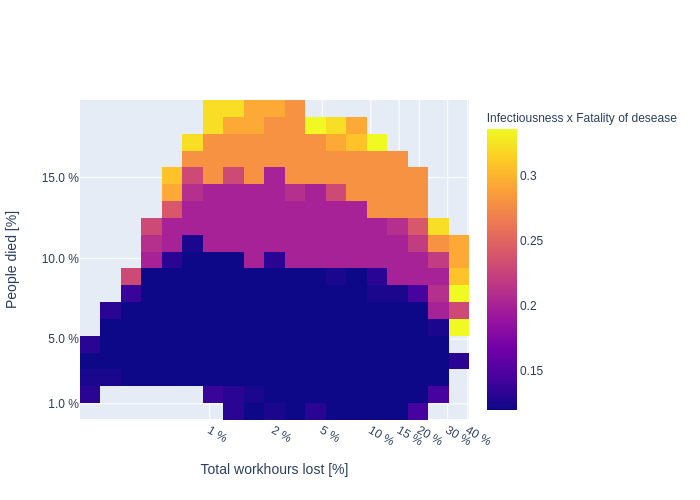

In [11]:
df_key_feat = df[["DEATH", "WORKING"]]
df_key_feat["FEAT1"] = X[:, x_cols.index("R_SPREAD_MULT_FATALITY")]
hist, d_steps, w_steps = hist2d.get2d_hist(df_key_feat, bins=20, x="DEATH", y="WORKING", z="FEAT1", reduce_op=np.min)

colorbar = dict(title="Infectiousness x Fatality of desease")
show_results(hist, w_steps, d_steps, colorbar)

## Predicting Economic loss

In [12]:
X_test, y_test, err = get_importance(X, df[["DEATH", "WORKING"]].values, 1, "Economic loss")

(213308, 264)
mean cross validation score: 0.8439462029823537
Coeff: KNOW_RATE_SICK_MULT_SD_IMPACT : 0.73321
Coeff: SD_START_ADD_SD_STOP : 0.09459
Coeff: FATALITY_ADD_KNOW_RATE_SICK : 0.06738
Coeff: SD_RECOVERED_ADD_SD_START : 0.05315
Coeff: SD_RECOVERED_ADD_SD_STOP : 0.01354
Coeff: SD_IMPACT_DIFF_SD_RECOVERED : 0.01275
Coeff: R_SPREAD_MULT_FATALITY : 0.00808
Coeff: FATALITY_SQR : 0.00668
Coeff: FATALITY_MULT_SD_IMPACT : 0.00565
Coeff: FATALITY_MULT_KNOW_RATE_SICK : 0.00497


#### Understanding error of predictions

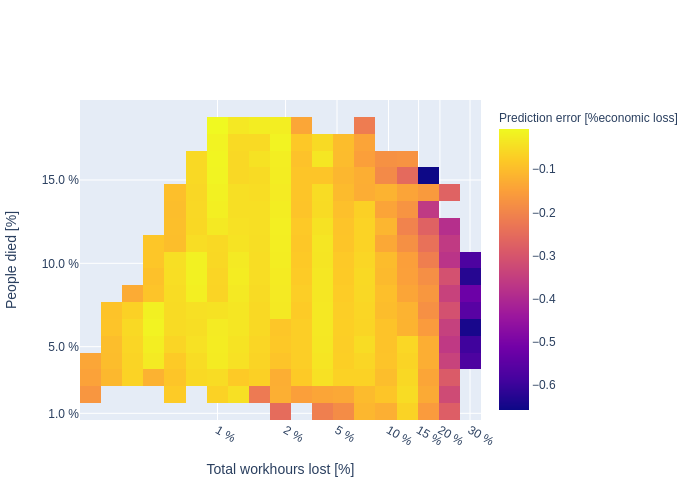

In [13]:
df_err = pandas.DataFrame(data={"WORKING":y_test[:, 1],
                            "DEATH": y_test[:, 0],
                            "error": err})
hist, d_steps, w_steps = hist2d.get2d_hist(df_err, bins=20, x="DEATH", y="WORKING", z="error", reduce_op=np.median)
#c_vals = np.log10([0.10, 0.25, 0.5, 0.75, 1.0, 2.0, 4.0])
colorbar = dict(title="Prediction error [%economic loss]")#, tickmode="array", tickvals=c_vals,
               #ticktext=[f"{10**c * 100:.0f}%" for c in c_vals])
show_results(hist, w_steps, d_steps, colorbar)

Given that we have a logarithmic scale for the economic loss. Higher levels of economic loss (right side) have high prediction errors. This indicates that the model and key features identified here, are only valid for areas on the left with higher death rates and smaller economic loss.

#### Economic loss key feature: KNOW_RATE_SICK_MULT_SD_IMPACT, i.e., Sick testing x Strength of social distancing

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



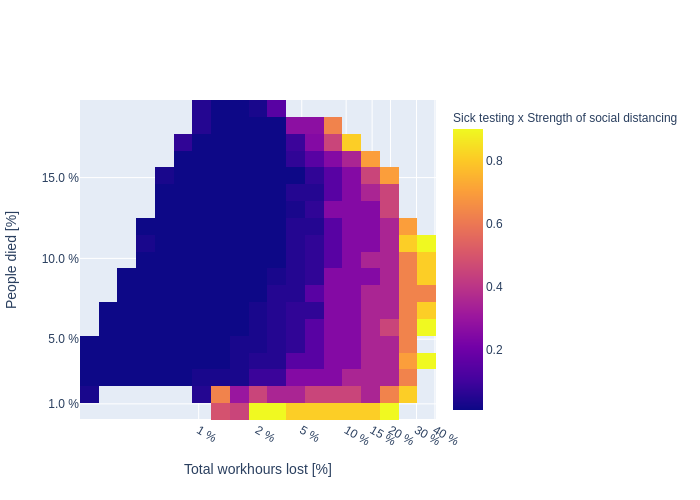

In [14]:
df_key_feat = df[["DEATH", "WORKING"]]
df_key_feat["FEAT1"] = X[:, x_cols.index("KNOW_RATE_SICK_MULT_SD_IMPACT")]
hist, d_steps, w_steps = hist2d.get2d_hist(df_key_feat, bins=20, x="DEATH", y="WORKING", z="FEAT1", reduce_op=np.min)

colorbar = dict(title="Sick testing x Strength of social distancing")
show_results(hist, w_steps, d_steps, colorbar)

So the simulation replicates facts that we would hope to replicate, i.e., the more we test and the stronger social distancing is active, the more we reduce death rate and increase economic loss.

## Predicting Economic loss (extremes > 15%)

As we have seen in the previous analysis, prediction errors increase towards the right side. Indicating that other factors play a critical role in getting beyond 15% of economic loss. So let's build a model for economic losses >15% and see what key features emerge here.

In [15]:
targets = df[["DEATH", "WORKING"]].values
inds = targets[:, 1] >= np.log10(0.15)
X_test, y_test, err = get_importance(X[inds, :], targets[inds, :], 1, "Economic loss")

(2802, 264)
mean cross validation score: 0.2898239175061859
Coeff: SD_START_ADD_SD_STOP : 0.26650
Coeff: KNOW_RATE_SICK_MULT_SD_IMPACT : 0.18637
Coeff: PARTY_FREQ_MULT_SD_RECOVERED : 0.11227
Coeff: SD_RECOVERED_ADD_SD_START : 0.09587
Coeff: PARTY_FREQ_DIV_SD_IMPACT : 0.08761
Coeff: PARTY_FREQ_ADD_SD_RECOVERED : 0.05696
Coeff: KNOW_RATE_SICK_DIV_SD_RECOVERED : 0.04834
Coeff: SD_STOP_SQRT : 0.03962
Coeff: PARTY_R_BOOST_DIFF_SD_IMPACT : 0.02524
Coeff: R_SPREAD_ADD_KNOW_RATE_SICK : 0.02333
Coeff: PARTY_R_BOOST_ADD_PARTY_FREQ : 0.02011
Coeff: PARTY_FREQ_ADD_SD_START : 0.01695
Coeff: FATALITY_DIFF_PARTY_R_BOOST : 0.01644
Coeff: index_DIV_R_SPREAD : 0.00439


Overall it seems like higher economic loss relates to the interaction between onset and offset of social distancing (SD_START + SD_STOP), as well as interaction between measures like Immune pass (SD_RECOVERED=True) and Corona parties (PARTY_FREQ). Still, the number of simulations is too low (2800) to have a high accuracy of the prediction (~29%). So one would need to rerun simulations with KNOW_RATE_SICK_MULT_SD_IMPACT > 0.9 and then vary the other factors.

## Predicting sick peak

In [16]:
X_test, y_test, err = get_importance(X, df[["DURATION", "SICK_PEAK"]].values, 1, "Peak of %sick")

(213308, 264)
mean cross validation score: 0.6998463325052781
Coeff: KNOW_RATE_SICK_MULT_SD_IMPACT : 0.67704
Coeff: SD_IMPACT_DIV_SD_START : 0.14030
Coeff: R_SPREAD_DIV_KNOW_RATE_SICK : 0.04951
Coeff: KNOW_RATE_SICK_ADD_SD_START : 0.03722
Coeff: KNOW_RATE_SICK_DIV_SD_START : 0.03041
Coeff: R_SPREAD_SQRT : 0.02848
Coeff: R_SPREAD_MULT_SD_START : 0.01235
Coeff: R_SPREAD_DIFF_KNOW_RATE_SICK : 0.00904
Coeff: PARTY_R_BOOST_MULT_PARTY_FREQ : 0.00733
Coeff: SD_IMPACT_DIFF_SD_START : 0.00517
Coeff: PARTY_FREQ_ADD_SD_START : 0.00315


#### Understanding error of predictions

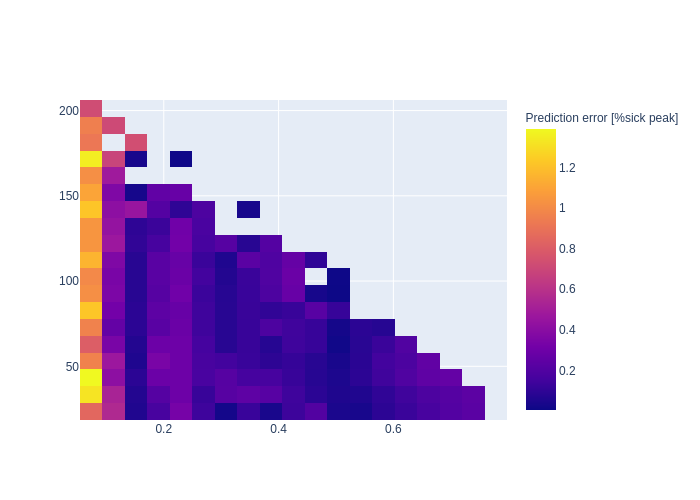

In [18]:
df_err = pandas.DataFrame(data={"SICK_PEAK":y_test[:, 1],
                            "DURATION": y_test[:, 0],
                            "error": err})
hist, d_steps, w_steps = hist2d.get2d_hist(df_err, bins=20, x="DURATION", y="SICK_PEAK", z="error", reduce_op=np.median)
#c_vals = np.log10([0.10, 0.25, 0.5, 0.75, 1.0, 2.0, 4.0])
colorbar = dict(title="Prediction error [%sick peak]")#, tickmode="array", tickvals=c_vals,
               #ticktext=[f"{10**c * 100:.0f}%" for c in c_vals])
fig = go.Figure(data=go.Heatmap(z=hist, x=w_steps, y=d_steps, hoverongaps = False, colorbar = colorbar))
#uncomment to get static version
Image(pio.to_image(fig, format='png'))
#uncomment to get interactive version
#fig.show()
#show_results(hist, w_steps, d_steps, colorbar)

#### Sick peak key feature: KNOW_RATE_SICK_MULT_SD_IMPACT, i.e., Sick testing x Strength of social distancing

/home/christian/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



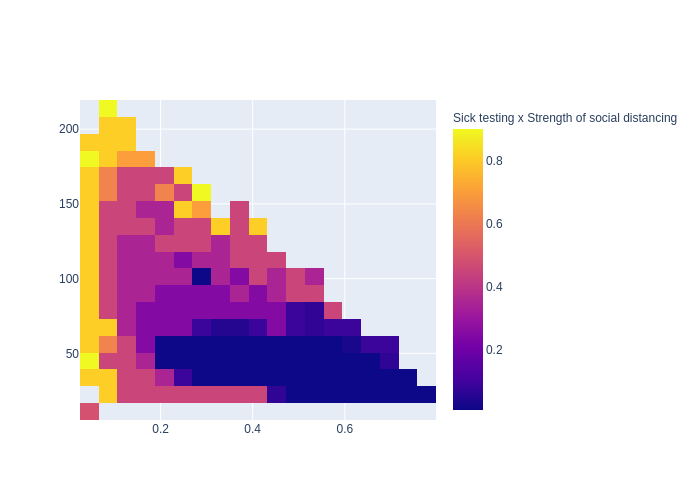

In [20]:
df_key_feat = df[["DURATION", "SICK_PEAK"]]
df_key_feat["FEAT1"] = X[:, x_cols.index("KNOW_RATE_SICK_MULT_SD_IMPACT")]
hist, d_steps, w_steps = hist2d.get2d_hist(df_key_feat, bins=20, x="DURATION", y="SICK_PEAK", z="FEAT1", reduce_op=np.min)

colorbar = dict(title="Sick testing x Strength of social distancing")
fig = go.Figure(data=go.Heatmap(z=hist, x=w_steps, y=d_steps, hoverongaps = False, colorbar = colorbar))
#uncomment to get static version
Image(pio.to_image(fig, format='png'))
#uncomment to get interactive version
#fig.show()

This is a similar picture than before, basically stating, that the stronger testing and social distancing reduces sick_peak but rather increases duration of the epidemic.

#### Sick peak key feature: SD_IMPACT_DIV_SD_START, i.e., Social distancing impact divided by onset of social distancing. The earlier and stronger social distancing is activated the higher this factor

In [1]:
df_key_feat = df[["DURATION", "SICK_PEAK"]]
df_key_feat["FEAT1"] = X[:, x_cols.index("SD_IMPACT_DIV_SD_START")]
hist, d_steps, w_steps = hist2d.get2d_hist(df_key_feat, bins=20, x="DURATION", y="SICK_PEAK", z="FEAT1", reduce_op=np.min)

colorbar = dict(title="Strength of social distancing divided by onset of social distancing")
fig = go.Figure(data=go.Heatmap(z=hist, x=w_steps, y=d_steps, hoverongaps = False, colorbar = colorbar))
#uncomment to get static version
Image(pio.to_image(fig, format='png'))
#uncomment to get interactive version
#fig.show()

NameError: name 'df' is not defined

Similar as above.